# Gráficas para latinoamerica

In [1]:
import pandas as pd
import os
from pathlib import Path
import numpy as np
import seaborn as sns
from datetime import date
from datetime import datetime
import matplotlib.pyplot as plt
from adjustText import adjust_text
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter, FixedLocator, MultipleLocator
import locale
plt.style.use('Solarize_Light2')
locale.setlocale(locale.LC_TIME, 'es_ES.UTF-8');

# Dataset
Dataset tomados de Center for Systems Science and Engineering (CSSE) at Johns Hopkins University

In [2]:
death_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
recovered_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
country_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_country.csv')

In [3]:
# renaming the df column names to lowercase
country_df.columns = map(str.lower, country_df.columns)
confirmed_df.columns = map(str.lower, confirmed_df.columns)
death_df.columns = map(str.lower, death_df.columns)
recovered_df.columns = map(str.lower, recovered_df.columns)

# changing province/state to state and country/region to country
confirmed_df = confirmed_df.rename(columns={'province/state': 'state', 'country/region': 'country'})
recovered_df = recovered_df.rename(columns={'province/state': 'state', 'country/region': 'country'})
death_df = death_df.rename(columns={'province/state': 'state', 'country/region': 'country'})
country_df = country_df.rename(columns={'country_region': 'country'})

In [4]:
def nuevos(country, df):
    temp = df[df['country'] == country ].iloc[:,4:]
    temp = (temp - temp.shift(axis=1)).T
    temp.fillna(0, inplace=True)
    return temp.values

In [5]:
def paises(country):
    df = pd.DataFrame() 
    df['date'] = pd.to_datetime(confirmed_df.iloc[:,4:].columns)
    df['casos'] = confirmed_df[confirmed_df['country'] == country ].iloc[:,4:].T.values
    df['casos_nuevos'] = nuevos(country=country, df=confirmed_df)

    df['muertes'] = death_df[death_df['country'] == country ].iloc[:,4:].T.values
    df['muertes_nuevas'] = nuevos(country=country, df=death_df)

    df['recuperados'] = recovered_df[recovered_df['country'] == country ].iloc[:,4:].T.values
    df['recuperados_nuevos'] = nuevos(country=country, df=recovered_df)

    df['activos'] = df['casos'] - df['muertes'] - df['recuperados']
    df['muertes %'] = round(( (df['muertes'] - df['muertes'].shift(1)) / df['muertes'].shift(1))*100,2)
    df['muertes nuevas %'] = round(( (df['muertes_nuevas'] - df['muertes_nuevas'].shift(1)) / df['muertes_nuevas'].shift(1))*100,2)
    df['casos %'] = round(( (df['casos'] - df['casos'].shift(1)) / df['casos'].shift(1))*100,2)
    df['casos nuevos %'] = round(( (df['casos_nuevos'] - df['casos_nuevos'].shift(1)) / df['casos_nuevos']
    .shift(1))*100,2)
    df['pais'] = country
    df.fillna(0,inplace=True)
    return df[df['casos']>0].reset_index().copy()

In [6]:
df_COL = paises('Colombia')
df_ARG = paises('Argentina')
df_BRA = paises('Brazil')
df_CHI = paises('Chile')
df_PER = paises('Peru')
df_PAR = paises('Paraguay')
df_URU = paises('Uruguay')
df_VEN = paises('Venezuela')
df_BOL = paises('Bolivia')
df_MEX = paises('Mexico')
df_ITA = paises('Italy')
df_ES = paises('Spain')

In [7]:
def rollingCases(df, cases, columnaConPromedio, columnaSinPromedio):
    df[columnaConPromedio] = df[columnaSinPromedio].rolling(7, win_type='gaussian').mean(std=2)
    # Se toma el indice desde que los casos superan X cantidad
    first_value = df[ df[columnaConPromedio] >= cases ].head(1)
    # Evita que paises que salga error con paises que no sobrepasan esta cifra
    if not first_value.empty:
        idx = first_value.index[0]
        df_temp = df.iloc[idx:]
        return df_temp.reset_index()
    else:
        return pd.DataFrame()

In [8]:
sns.set()
#plt.style.context('Solarize_Light2')
def graficar(list_df, columna, titulo, xlabel, ylabel):
    #plt.style.use('fivethirtyeight')
    plt.style.use('Solarize_Light2')
    plt.figure(figsize=(10,6), dpi=300)
    plt.margins(0,0.01)
    for df in list_df:
        if not df.empty:
            name = df['pais'].iloc[0]
            fig = sns.lineplot(x = df.index, y = columna, data = df, legend=False)  
            if name == 'Colombia':
                size = 18
            else:
                size = 14
            fig.annotate(name, 
                xy=(df.index[-1], df[columna].iloc[-1]), 
                xytext=(6,0), 
                color= plt.gca().lines[-1].get_color() ,  
                textcoords="offset points",
                size=size, va="center",weight='bold')    

    ax = plt.gca()
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.yaxis.set_major_locator(FixedLocator([1,3,5,10,30,50,100,300,500,1000,3000,5000,10000,30000,50000,100000,300000,500000,1000000]))
    ax.xaxis.set_major_locator(MultipleLocator(10))
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=16)
    plt.title(titulo, fontsize=18)
    plt.gcf().text(0.55, 0.15, texto, fontsize=10)
    plt.savefig(f'{columna}{fecha}.png', facecolor='w', bbox_inches='tight')
    plt.show()

In [9]:
df1 = rollingCases(df_COL, 100, 'mean_cases', 'casos')
df3 = rollingCases(df_ARG, 100, 'mean_cases', 'casos')
df4 = rollingCases(df_CHI, 100, 'mean_cases', 'casos')
df5 = rollingCases(df_PER, 100, 'mean_cases', 'casos')
df6 = rollingCases(df_BRA, 100, 'mean_cases', 'casos')
df7 = rollingCases(df_BOL, 100, 'mean_cases', 'casos')
df8 = rollingCases(df_URU, 100, 'mean_cases', 'casos')
df9 = rollingCases(df_MEX, 100, 'mean_cases', 'casos')
df10 = rollingCases(df_PAR, 100, 'mean_cases', 'casos')
df11 = rollingCases(df_VEN, 100, 'mean_cases', 'casos')
df12 = rollingCases(df_ITA, 100, 'mean_cases', 'casos')
df13 = rollingCases(df_ES, 100, 'mean_cases', 'casos')

In [10]:
df_1 = rollingCases(df_COL, 30, 'mean_new_cases', 'casos_nuevos')
df_3 = rollingCases(df_ARG, 30, 'mean_new_cases', 'casos_nuevos')
df_4 = rollingCases(df_CHI, 30, 'mean_new_cases', 'casos_nuevos')
df_5 = rollingCases(df_PER, 30, 'mean_new_cases', 'casos_nuevos')
df_6 = rollingCases(df_BRA, 30, 'mean_new_cases', 'casos_nuevos')
df_7 = rollingCases(df_BOL, 30, 'mean_new_cases', 'casos_nuevos')
df_8 = rollingCases(df_URU, 30, 'mean_new_cases', 'casos_nuevos')
df_9 = rollingCases(df_MEX, 30, 'mean_new_cases', 'casos_nuevos')
df_10 = rollingCases(df_PAR, 30, 'mean_new_cases', 'casos_nuevos')
df_11 = rollingCases(df_VEN, 30, 'mean_new_cases', 'casos_nuevos')
df_12 = rollingCases(df_ITA, 30, 'mean_new_cases', 'casos_nuevos')
df_13 = rollingCases(df_ES, 30, 'mean_new_cases', 'casos_nuevos')

In [11]:
df_deaths_1 = rollingCases(df_COL, 10, 'mean_deaths', 'muertes')
df_deaths_3 = rollingCases(df_ARG, 10, 'mean_deaths', 'muertes')
df_deaths_4 = rollingCases(df_CHI, 10, 'mean_deaths', 'muertes')
df_deaths_5 = rollingCases(df_PER, 10, 'mean_deaths', 'muertes')
df_deaths_6 = rollingCases(df_BRA, 10, 'mean_deaths', 'muertes')
df_deaths_7 = rollingCases(df_BOL, 10, 'mean_deaths', 'muertes')
df_deaths_8 = rollingCases(df_URU, 10, 'mean_deaths', 'muertes')
df_deaths_9 = rollingCases(df_MEX, 10, 'mean_deaths', 'muertes')
df_deaths_10 = rollingCases(df_PAR, 10, 'mean_deaths', 'muertes')
df_deaths_11 = rollingCases(df_VEN, 10, 'mean_deaths', 'muertes')
df_deaths_12 = rollingCases(df_ITA, 10, 'mean_deaths', 'muertes')
df_deaths_13 = rollingCases(df_ES, 10, 'mean_deaths', 'muertes')

In [12]:
df_daily_deaths_1 = rollingCases(df_COL, 3, 'mean_daily_deaths', 'muertes_nuevas')
df_daily_deaths_3 = rollingCases(df_ARG, 3, 'mean_daily_deaths', 'muertes_nuevas')
df_daily_deaths_4 = rollingCases(df_CHI, 3, 'mean_daily_deaths', 'muertes_nuevas')
df_daily_deaths_5 = rollingCases(df_PER, 3, 'mean_daily_deaths', 'muertes_nuevas')
df_daily_deaths_6 = rollingCases(df_BRA, 3, 'mean_daily_deaths', 'muertes_nuevas')
df_daily_deaths_7 = rollingCases(df_BOL, 3, 'mean_daily_deaths', 'muertes_nuevas')
df_daily_deaths_8 = rollingCases(df_URU, 3, 'mean_daily_deaths', 'muertes_nuevas')
df_daily_deaths_9 = rollingCases(df_MEX, 3, 'mean_daily_deaths', 'muertes_nuevas')
df_daily_deaths_10 = rollingCases(df_PAR, 3, 'mean_daily_deaths', 'muertes_nuevas')
df_daily_deaths_11 = rollingCases(df_VEN, 3, 'mean_daily_deaths', 'muertes_nuevas')
df_daily_deaths_12 = rollingCases(df_ITA, 3, 'mean_daily_deaths', 'muertes_nuevas')
df_daily_deaths_13 = rollingCases(df_ES, 3, 'mean_daily_deaths', 'muertes_nuevas')

In [13]:
list_df1 = [df1 , df3, df4, df5, df6, df7, df8, df9, df10, df11,df12]
list_df2 = [df_1 , df_3, df_4, df_5, df_6, df_7, df_8, df_9,df_11, df_12]
list_df_deaths = [df_deaths_1,df_deaths_3,df_deaths_4,df_deaths_5,
                  df_deaths_6,df_deaths_7,df_deaths_8,df_deaths_9, df_deaths_10, df_deaths_11, df_deaths_12]
list_df_daily_deaths = [df_daily_deaths_1,df_daily_deaths_3,
                        df_daily_deaths_4,df_daily_deaths_5,df_daily_deaths_6,
                        df_daily_deaths_7,df_daily_deaths_8,df_daily_deaths_9, df_daily_deaths_10, df_daily_deaths_11,df_daily_deaths_12]
fecha = date.today()
fecha_cool = datetime.strftime(fecha,'%B %d')
fecha = str(fecha)
texto = f'Johns Hopkins University - @JairoTorregrose - {fecha_cool}'

In [14]:
titulo_casos_acumulados = 'Casos acumulados confirmados con media móvil de 7 días'
xlabel_casos_acumulados = 'Número de días desde los primeros 100 casos'
ylabel_casos_acumulados = 'Casos acumulados'

titulo_casos_diarios = 'Casos diarios confirmados con media móvil de 7 días'
xlabel_casos_diarios = 'Número de días desde los primeros 30 casos diarios'
ylabel_casos_diarios = 'Casos diarios'

titulo_muertes_acumuladas = 'Muertes acumuladas con media móvil de 7 días'
xlabel_muertes_acumuladas = 'Número de días desde las primeras 10 muertes'
ylabel_muertes_acumuladas = 'Muertes acumuladas'

titulo_muertes_diarias = 'Muertes diarias con media móvil de 7 días'
xlabel_muertes_diarias = 'Número de días desde las primeras 3 muertes diarias'
ylabel_muertes_diarias = 'Muertes diarias'

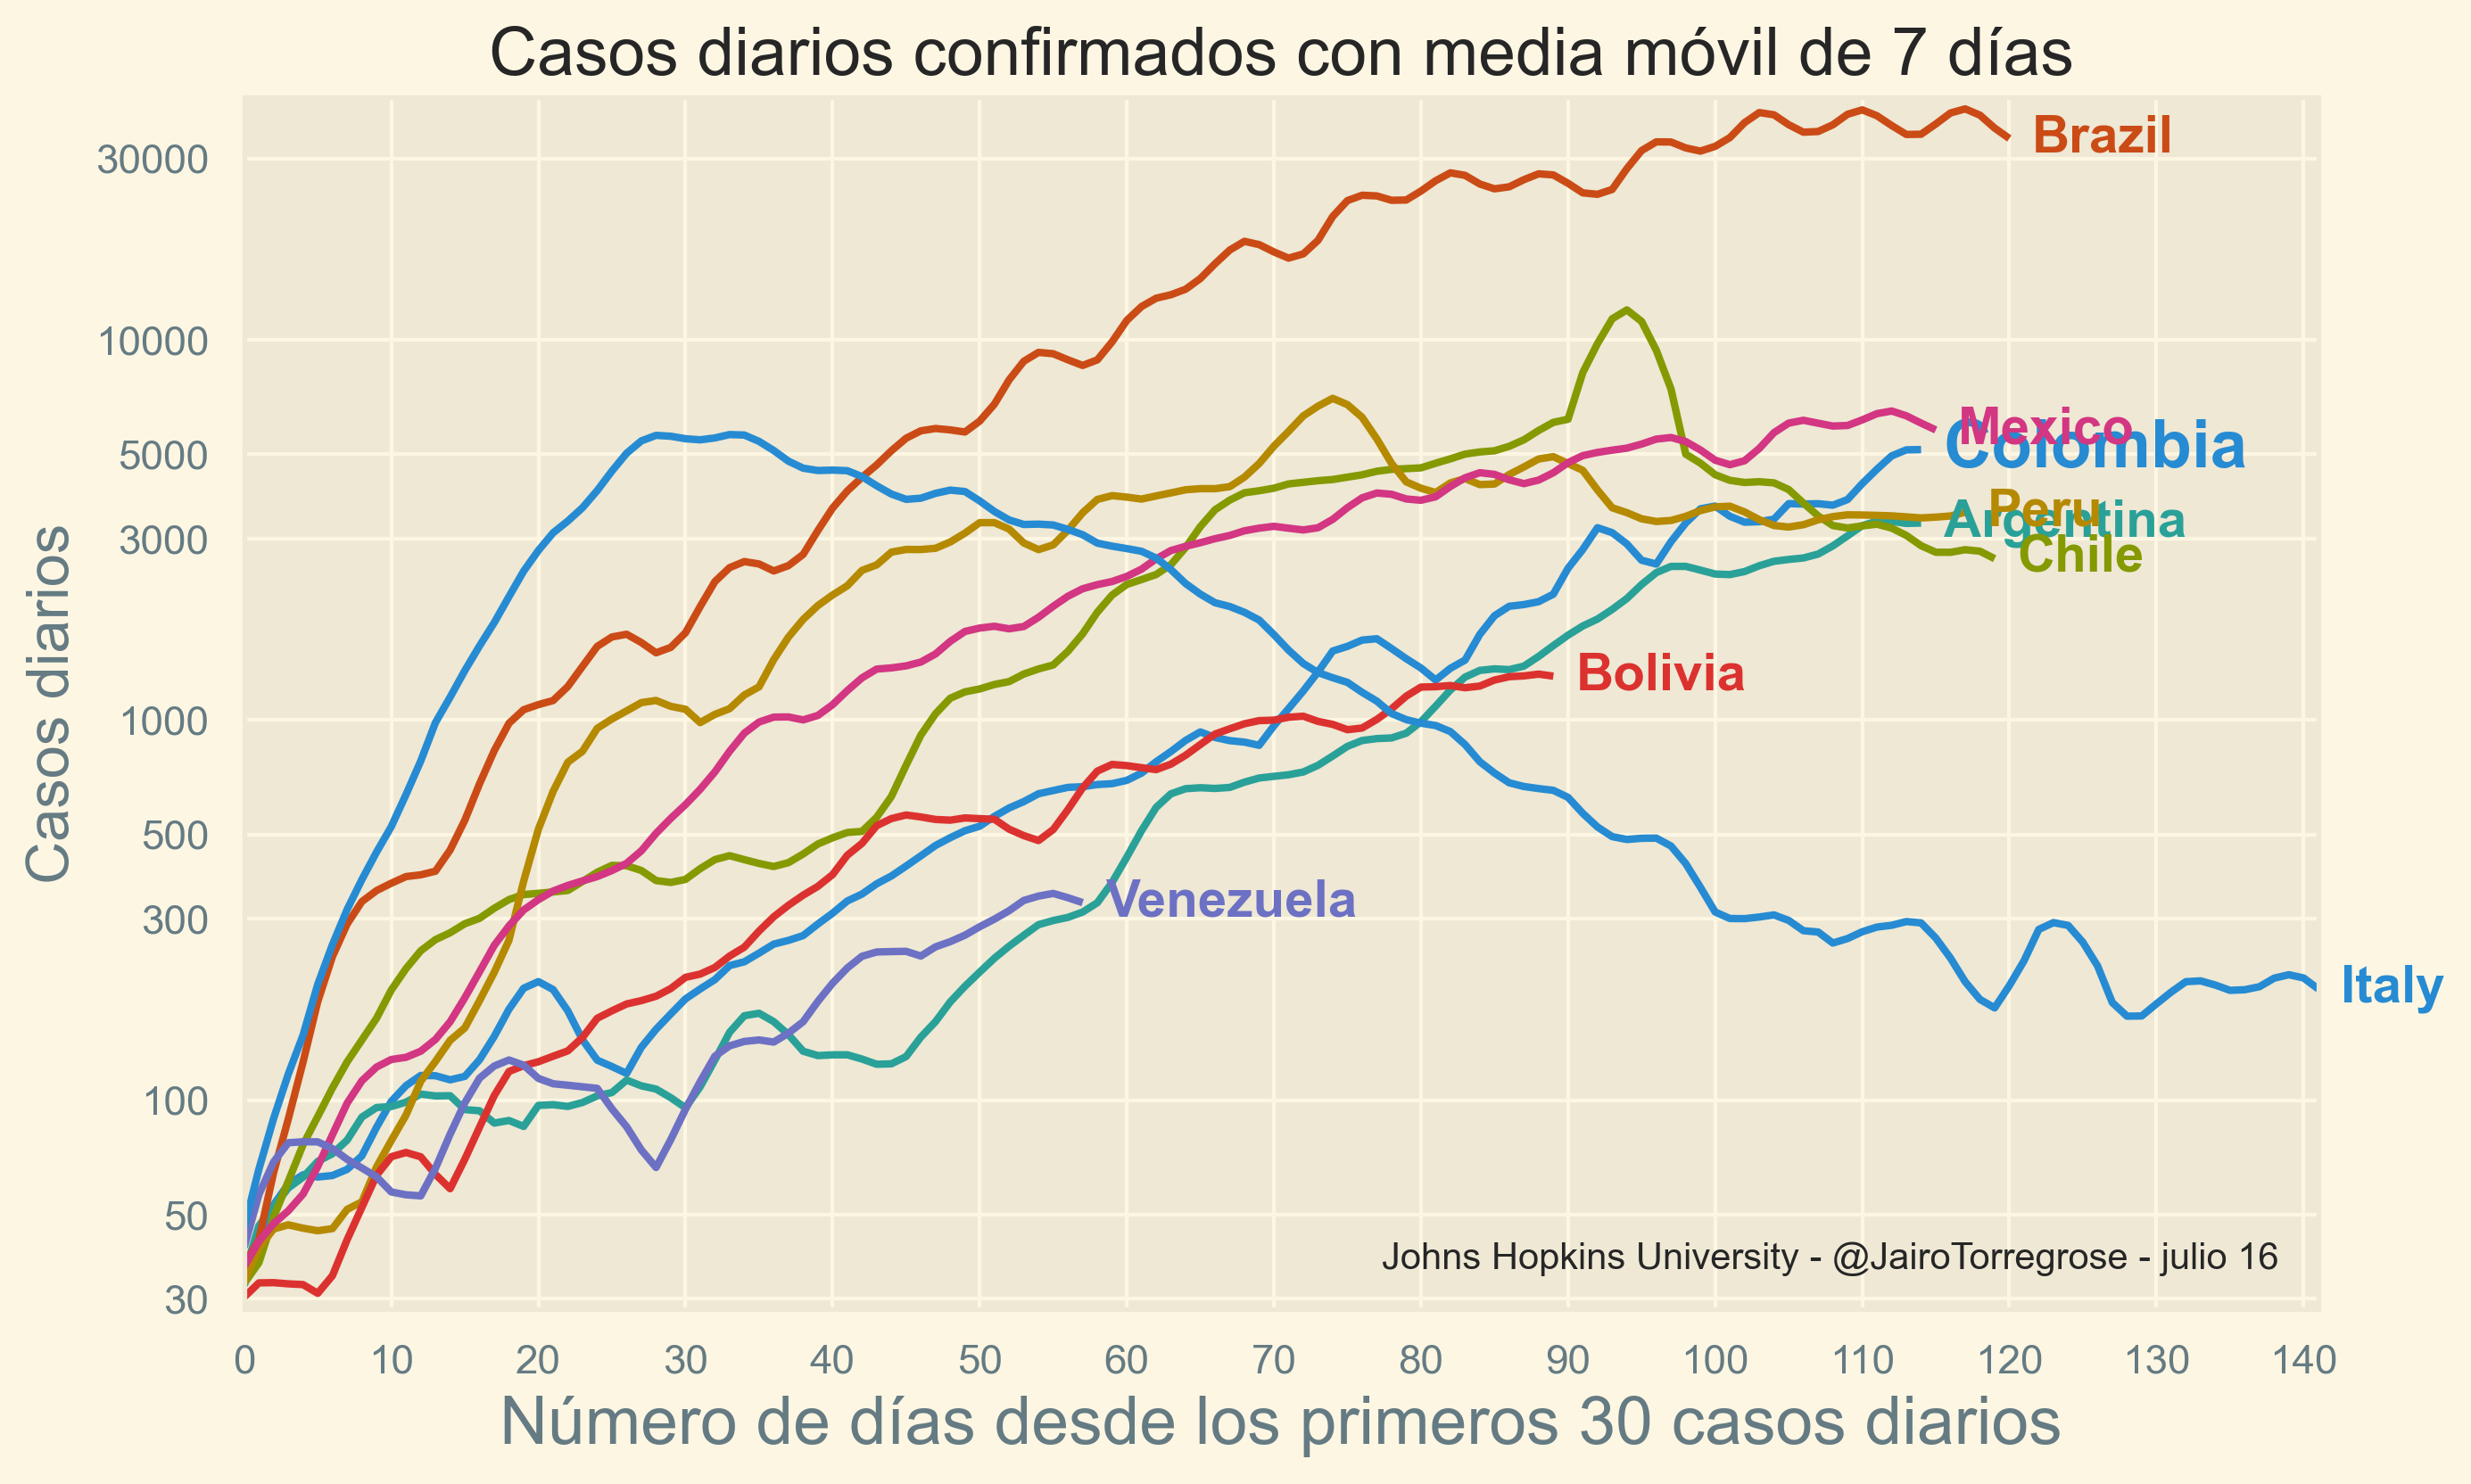

In [15]:
graficar(list_df2, 'mean_new_cases', titulo_casos_diarios, xlabel_casos_diarios, ylabel_casos_diarios)

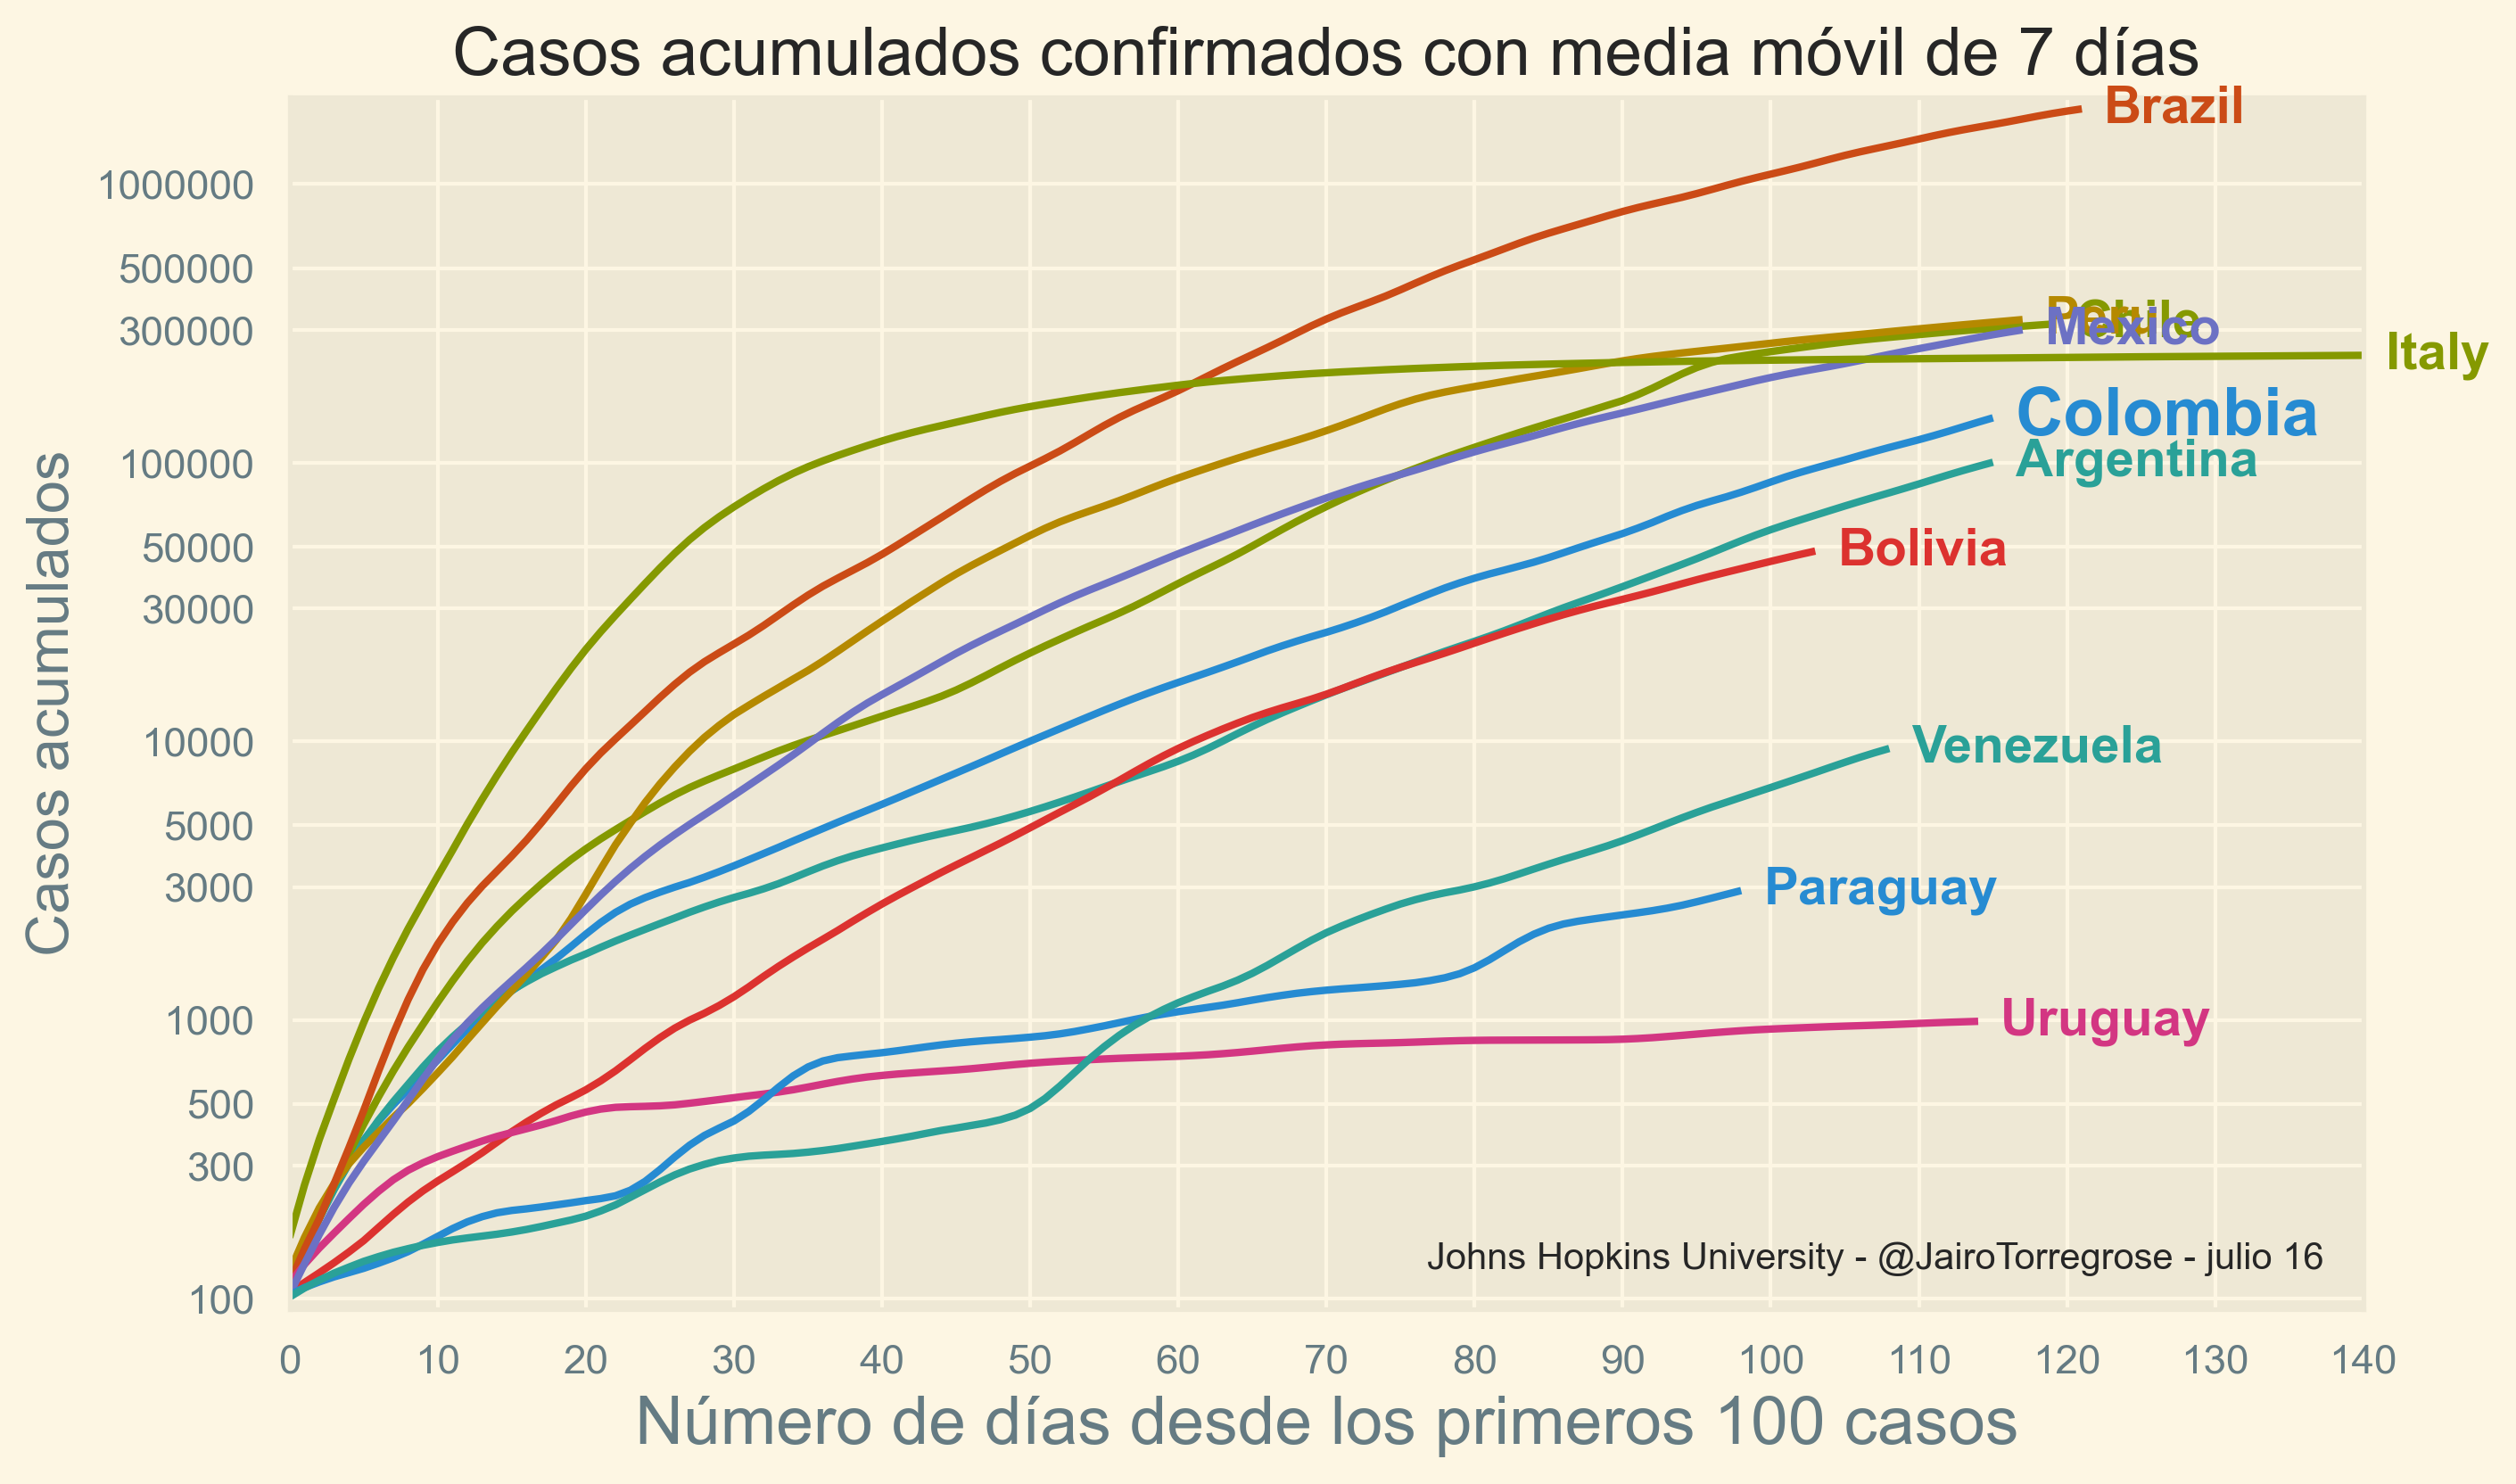

In [16]:
graficar(list_df1, 'mean_cases', titulo_casos_acumulados, xlabel_casos_acumulados, ylabel_casos_acumulados)

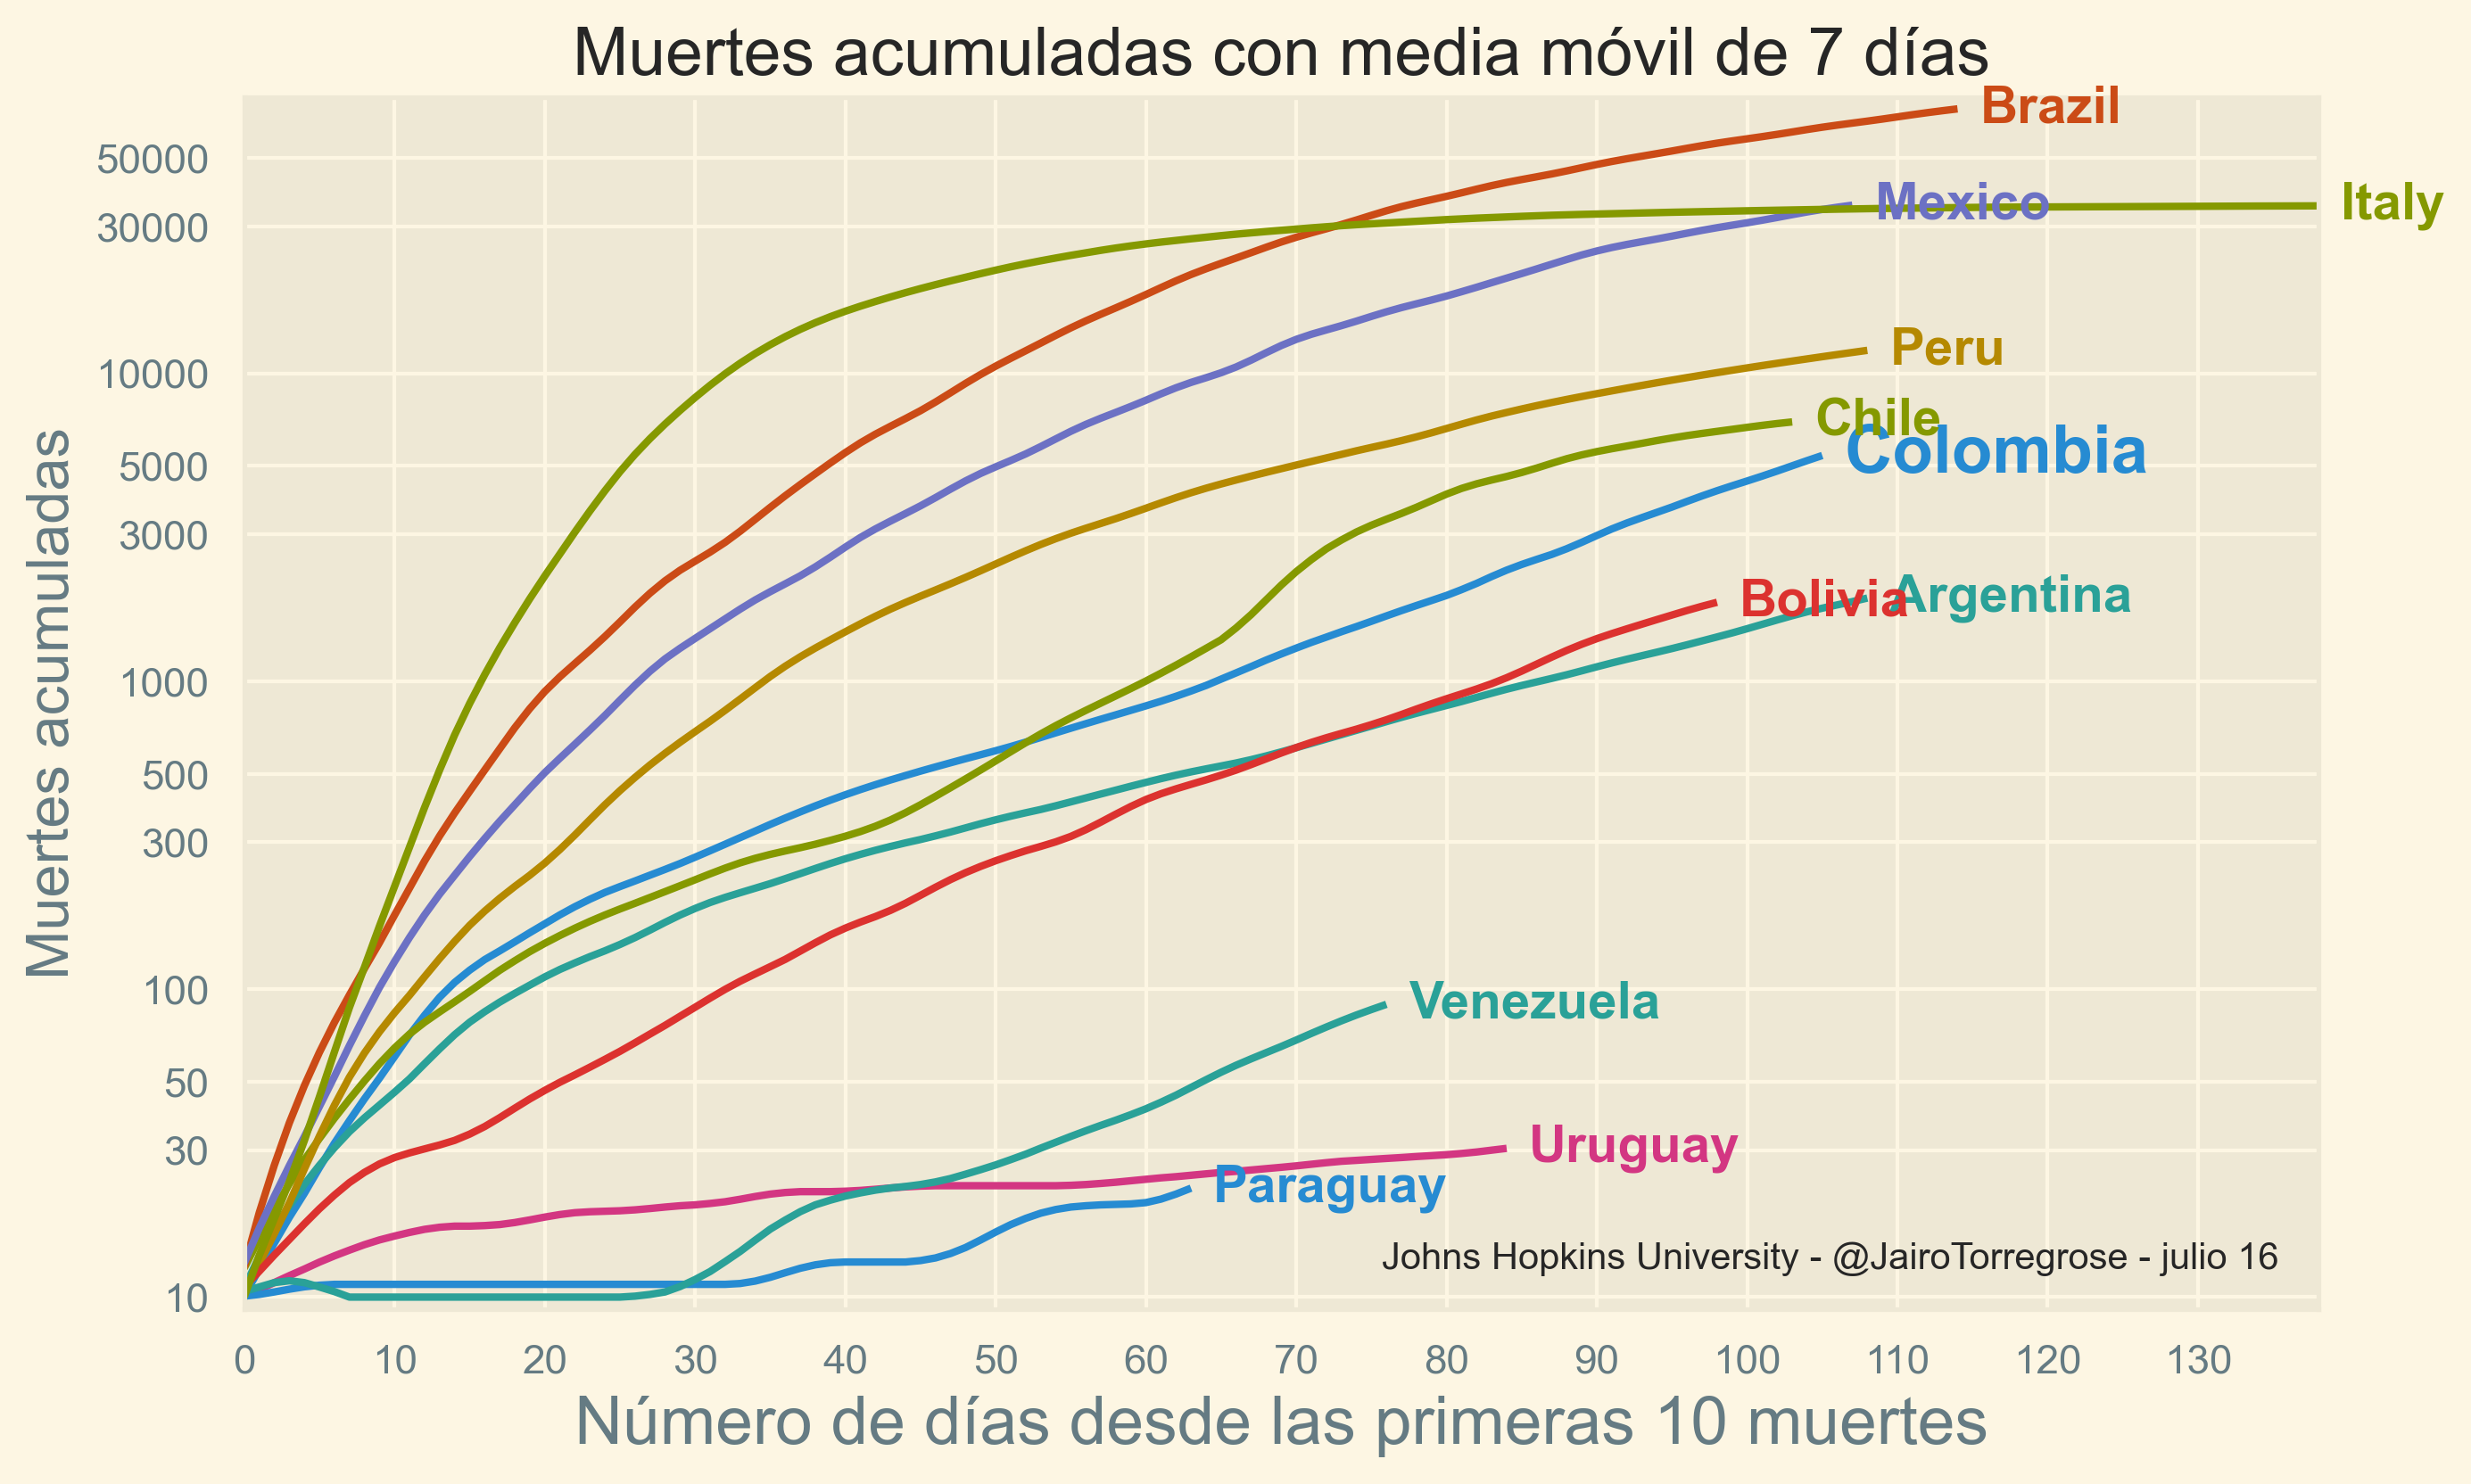

In [17]:
graficar(list_df_deaths, 'mean_deaths', titulo_muertes_acumuladas, xlabel_muertes_acumuladas, ylabel_muertes_acumuladas)

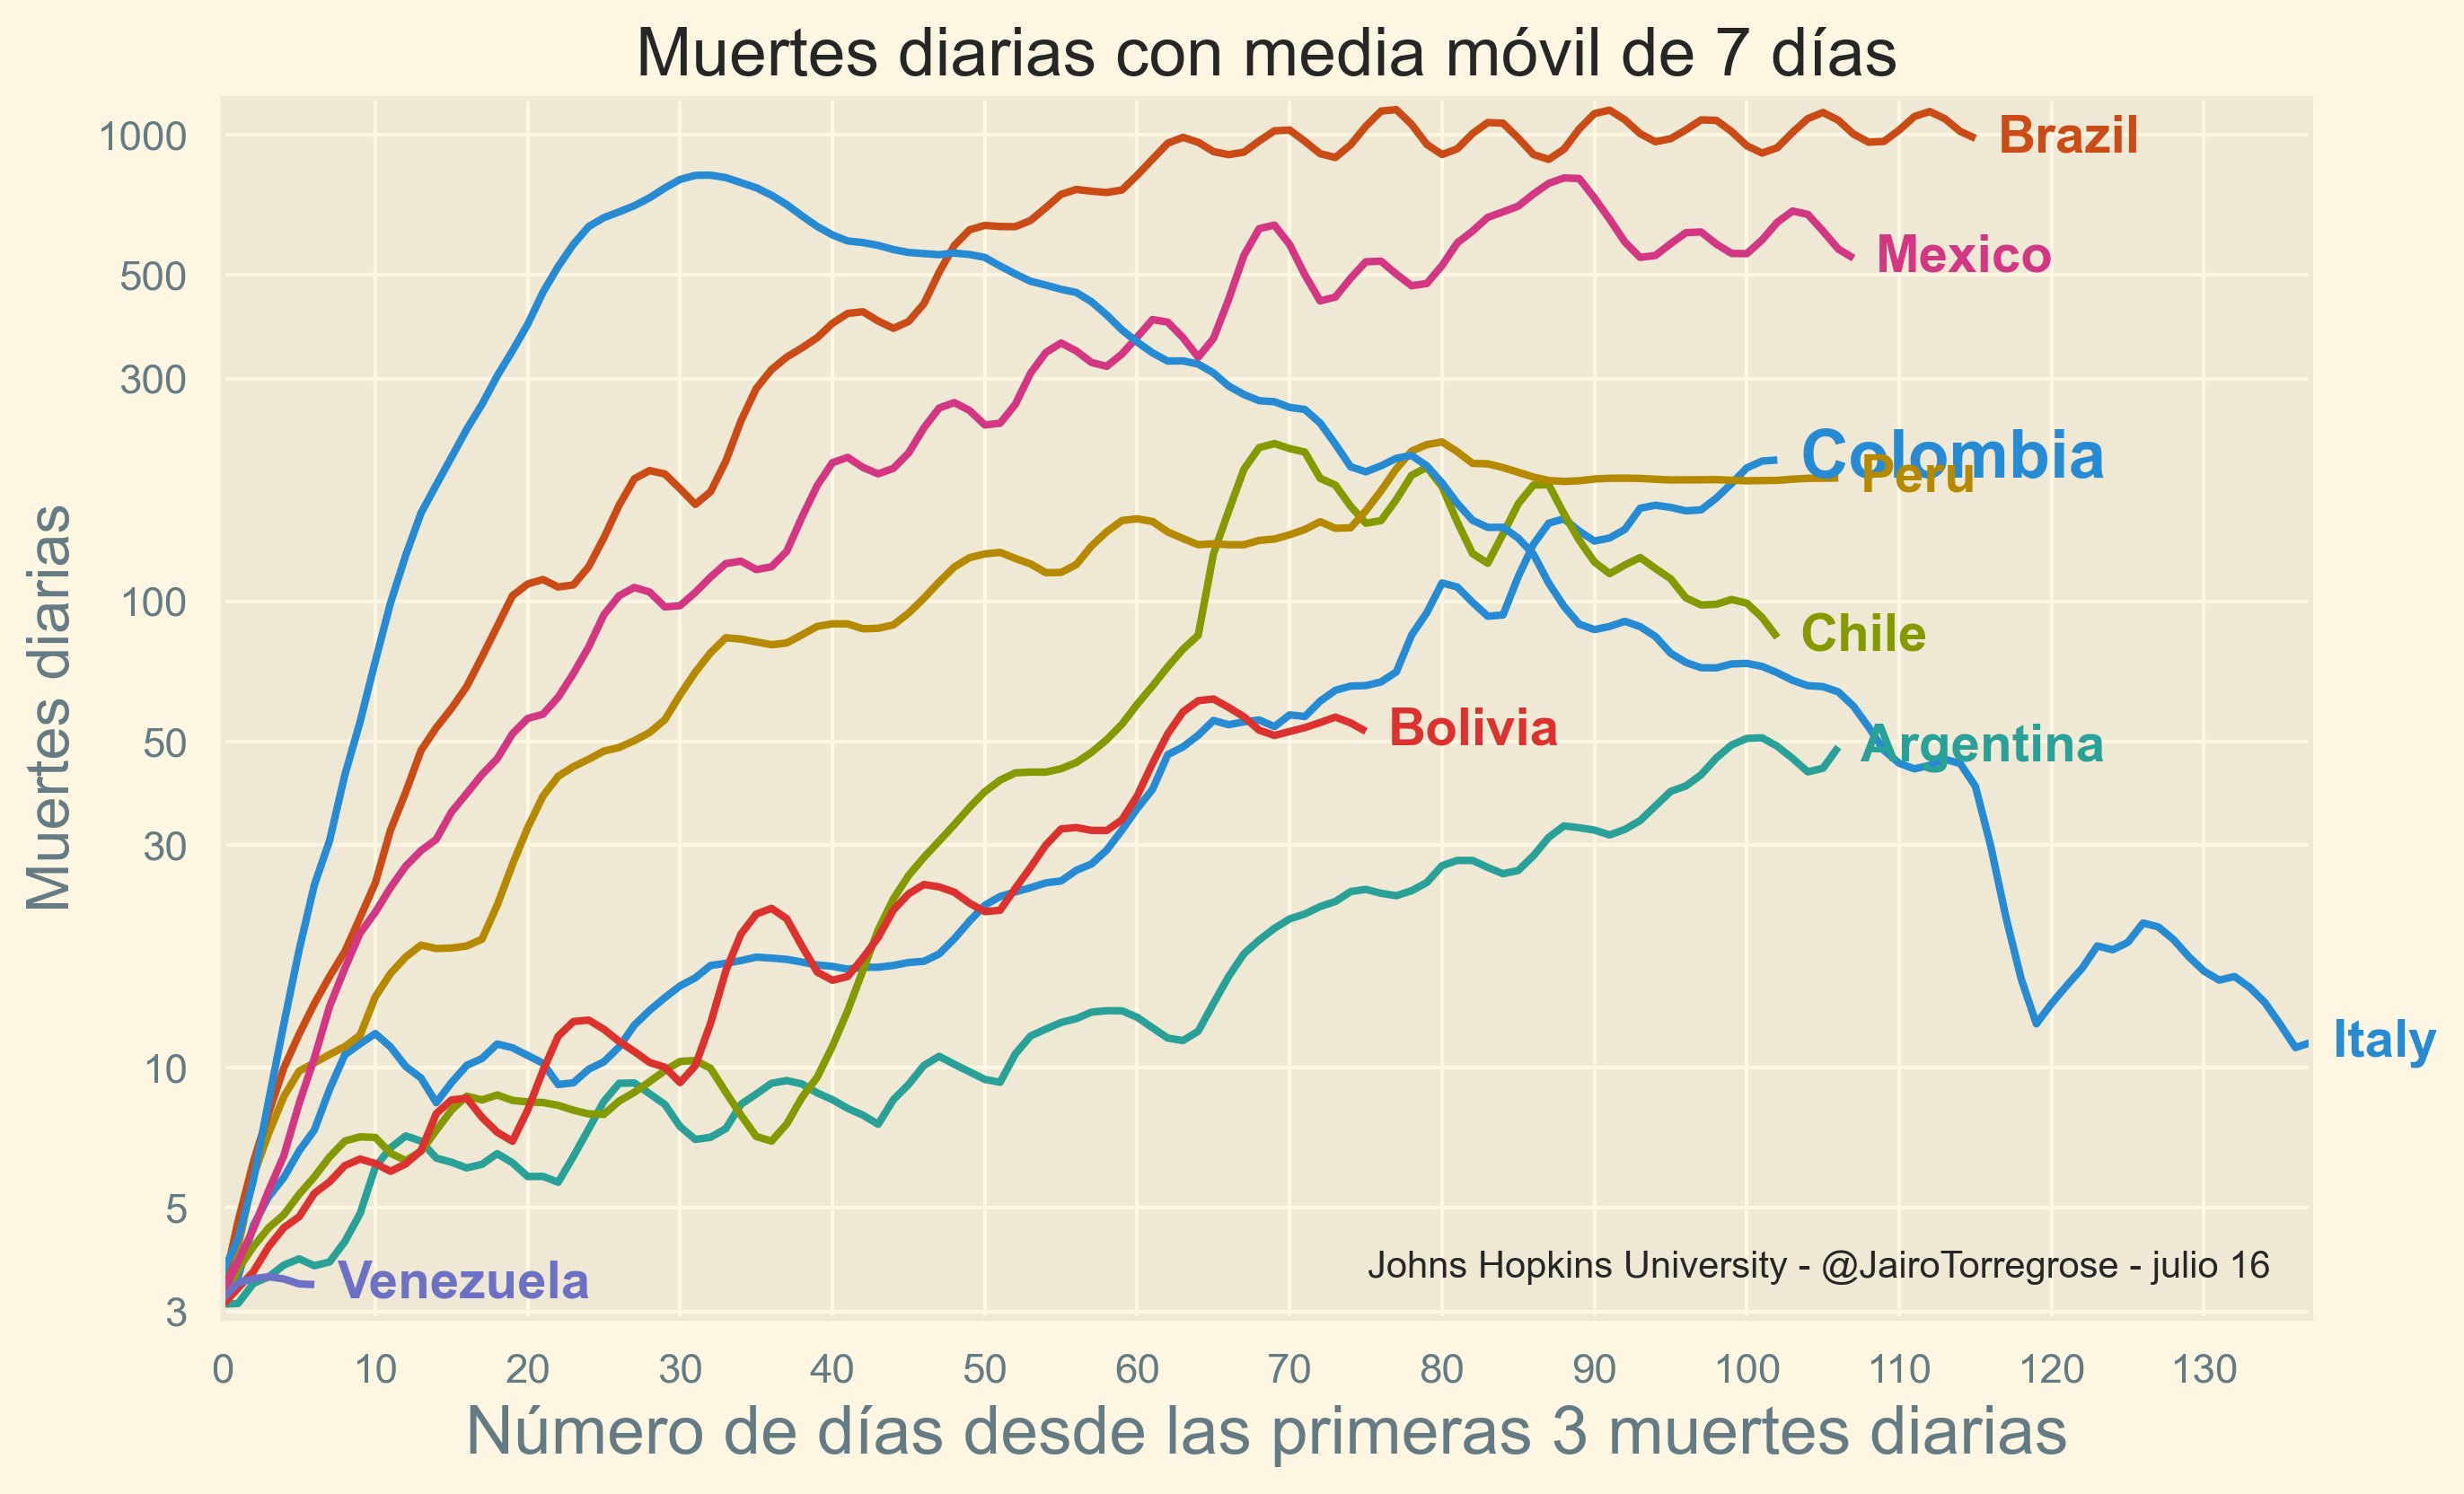

In [18]:
graficar(list_df_daily_deaths, 'mean_daily_deaths', titulo_muertes_diarias, xlabel_muertes_diarias, ylabel_muertes_diarias)